In [29]:
import os
# For windows
# os.environ['PROJ_LIB'] = 'C:\Anaconda\Library\share'

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import LinearNDInterpolator
from pyproj import transform, Proj

plt.rcParams['animation.ffmpeg_path'] = '/home/etsu/miniconda2/envs/particles/bin/ffmpeg'

In [51]:
# зададим константы
NUM_PARTICLES = 100
NUM_ITER = 24
STEP = 3600  # sec
SEED = 45

In [52]:
# системы координат
wgs84 = Proj(init="EPSG:4326")
local_crs = Proj(init="EPSG:2463")

In [53]:
# получаем данные из файла
data = np.genfromtxt('6.csv', delimiter=';', skip_header=True)
data[data==-999] = np.nan
lonlat, velocity = data[:, 1::-1], data[:, 2:]
velocity *= 0.01  # переведем из см/с в м/с

x, y = transform(wgs84, local_crs, lonlat[:, 0], lonlat[:, 1])
xy = np.vstack([x, y]).T

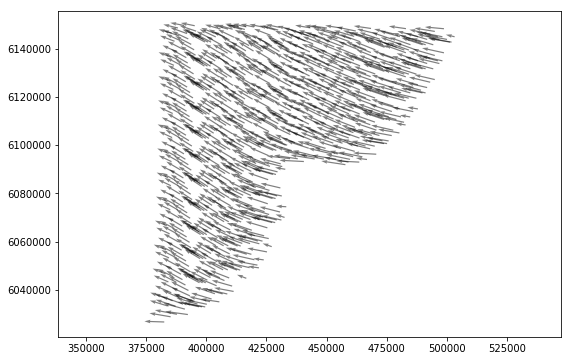

In [54]:
# посмотрим на данные
fig, ax = plt.subplots(figsize=(9,6))
ax.quiver(xy[::10, 0], xy[::10, 1], velocity[::10, 0], velocity[::10, 1], scale=2, scale_units='width', alpha=0.5)
ax.axis('equal')
pass

In [55]:
# создадим функцию интерполяции данных
get_velocity = LinearNDInterpolator(xy, velocity)

In [56]:
# получим гранницы данных
bounds = np.hstack([xy.min(axis=0), xy.max(axis=0)])
bounds_lonlat = np.hstack([lonlat.min(axis=0), lonlat.max(axis=0)])

In [57]:
# рассчитаем состояние системы на каждой итерации для каждой частицы
# state - 3-мерный массив [NUM_ITER х NUM_PARTICLES х 4]
# по последней оси размерностью 4 храним X, Y, Vx, Vy
def init_state(bounds, num_particles, seed=None):
    """Инициализация состояния системы"""
    x_min, y_min, x_max, y_max = bounds
    rs = np.random.RandomState(seed)
    x = rs.uniform(x_min, x_max, num_particles)
    y = rs.uniform(y_min, y_max, num_particles)
    xy = np.vstack([x, y]).T
    velocity = get_velocity(xy)
    return np.hstack([xy, velocity])

def get_state(state_prev, step):
    """Получает текущее состояние по предыдущему"""
    xy_prev = state_prev[:, :2]
    velocity_prev = state_prev[:, 2:]
    xy_cur = xy_prev + step*velocity_prev
    velocity_cur = get_velocity(xy_cur)
    states_cur = np.hstack([xy_cur, velocity_cur])
    return states_cur

states = np.ones([NUM_ITER, NUM_PARTICLES, 4], dtype=float) * np.nan
states[0, :, :] = init_state(bounds, NUM_PARTICLES, seed=None)
for n in range(1, NUM_ITER):
    states[n, :, :] = get_state(states[n-1, :, :], STEP)

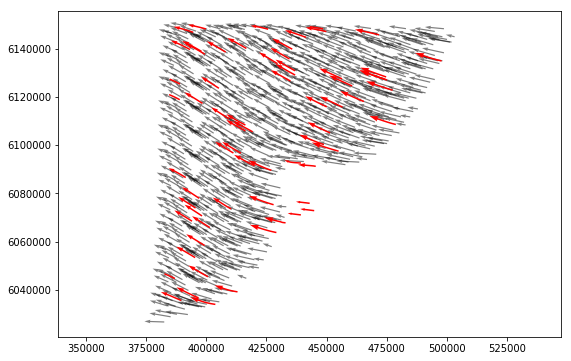

In [58]:
# посмотрим на получившиеся треки
i=NUM_ITER-1
fig, ax = plt.subplots(figsize=(9,6))
ax.quiver(xy[::10, 0], xy[::10, 1], velocity[::10, 0], velocity[::10, 1], scale=2, scale_units='width', alpha=0.5)
ax.plot(states[0:i+1, :, 0], states[0:i+1, :, 1], color='red')
ax.quiver(states[i, :, 0], states[i, :, 1], states[i, :, 2], states[i, :, 3], color='red', scale=5)
ax.axis('equal')
pass

In [59]:
# сейчас координаты в states мы рассчитали в метрах
# переведем их в wgs84, чтобы отобразить на карте
def to_wgs84(xy):
    """Конвертация в wgs84"""
    if np.isnan(xy).any():
        return np.ones(2)*np.nan
    return transform(local_crs, wgs84, xy[0], xy[1])

for i in range(states.shape[0]):
    states[i, :, :2] = np.apply_along_axis(
        func1d=to_wgs84,
        axis=1,
        arr=states[i, :, :2]
    )

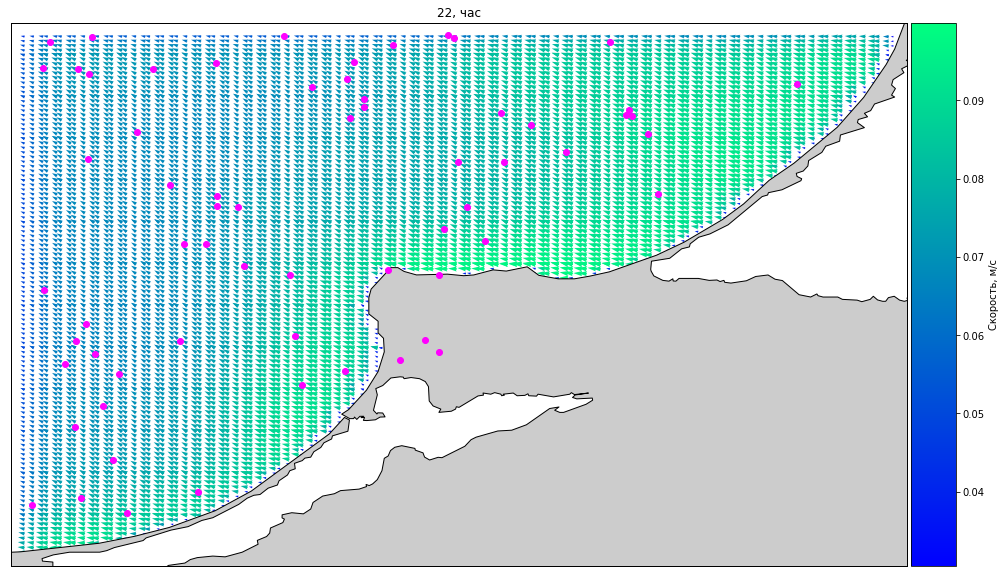

In [62]:
# рисуем анимацию

# создаем рисунок
fig, ax = plt.subplots(figsize=(20,10))

# добавляем континенты
m = Basemap(
    llcrnrlon=bounds_lonlat[0]-0.03,
    llcrnrlat=bounds_lonlat[1]-0.03,
    urcrnrlon=bounds_lonlat[2]+0.03,
    urcrnrlat=bounds_lonlat[3]+0.03,
    epsg="4326",
    resolution='h',
)
m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()

# добавляем поле скоростей
q = ax.quiver(
    lonlat[:, 0],
    lonlat[:, 1],
    velocity[:, 0],
    velocity[:, 1],
    np.linalg.norm(velocity, axis=1),
    scale=10,
    width=0.002,
    cmap='winter'
)

# добавляем colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(q, cax=cax, label='Скорость, м/с')
lines = []
for i in range(states.shape[1]):
    lines.append(ax.plot([], [], color='magenta', linestyle='', marker='o')[0])

# инициализация линий для анимации
def init():
    for line in lines:
        line.set_data([],[])
    return lines

# обновлении линий на каждой итерации
def update(frame):
    ax.set_title('{}, час'.format(frame*STEP//3600))
    for i, line in enumerate(lines):
        x = states[frame:frame+1, i, 0]
        y = states[frame:frame+1, i, 1]
        line.set_data(x, y)
    return lines

# cоздаем и сохраняем анимацию
ani = animation.FuncAnimation(
    fig,
    update,
    frames=np.arange(NUM_ITER-1),
    init_func=init,
    interval=200,
    blit=True,
)
ani.save('animation.mp4',  writer=animation.FFMpegFileWriter())